In [6]:
#@title Load Libraries
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2

# prepare data

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [8]:
unlabeld_index = np.ones(y_train.shape, np.bool)

N = 20
for i in range(10):
  idx = np.where(y_train == i)[0][:N]
  unlabeld_index[idx] = 0

In [9]:
x_unlabeld = x_train[np.where(unlabeld_index)[0], ...]

x_train = x_train[np.where(~unlabeld_index)[0], ...]
y_train = y_train[np.where(~unlabeld_index)[0], ...]

In [10]:
print(len(x_unlabeld))
print(x_unlabeld.shape)

print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

49800
(49800, 32, 32, 3)
200
200
10000
10000


In [11]:
# examples of categorical crossentropy
cce = keras.losses.CategoricalCrossentropy()

# a labeled data from the second class
y_true = [[0, 1, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# an ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# another ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.1, 0.4, 0.3, 0.2]]
print(cce(y_true, y_pred).numpy())

0.051293306
0.0
0.0


In [12]:
# normalize
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255

In [13]:
# convert label to one hot
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


# First model
training with 200 labeled data

In [18]:
model = tf.keras.Sequential()

# define regularization norm 2
reg = tf.keras.regularizers.l2(0.001)

# input layer
# model.add(tf.keras.Input(X_train[0].shape))  # 32x32 RGB images
model.add(tf.keras.layers.Input((32,32,3)))

# create the base model
# First convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer=reg, name='conv_1'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_1'))
model.add(tf.keras.layers.Activation('relu', name='Act_1'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_1'))

# Second convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer=reg, name='conv_2'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_2'))
model.add(tf.keras.layers.Activation('relu', name='Act_2'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_2'))

# Third convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer=reg, name='conv_3'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_3'))
model.add(tf.keras.layers.Activation('relu', name='Act_3'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_3'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_3'))

# add a Flatten layer
model.add(tf.keras.layers.Flatten(name='Flatten'))

# let's add fully-connected layers
model.add(tf.keras.layers.Dense(1024, kernel_regularizer=reg, name='Dense_1'))
model.add(tf.keras.layers.Activation('relu', name='Act_4'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_4'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_4'))

model.add(tf.keras.layers.Dense(128, kernel_regularizer=reg, name='Dense_2'))
model.add(tf.keras.layers.Activation('relu', name='Act_5'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_5'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_5'))


# and a logistic layer -- let's say we have 10 classes
model.add(tf.keras.layers.Dense(10, kernel_regularizer=reg, name='Dense_3'))
model.add(tf.keras.layers.Activation('softmax', name='Act_6'))

# compile the model
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=0.001), loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 128)       3584      
_________________________________________________________________
BatchN_1 (BatchNormalization (None, 30, 30, 128)       512       
_________________________________________________________________
Act_1 (Activation)           (None, 30, 30, 128)       0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 15, 15, 128)       0         
_________________________________________________________________
Drop_1 (Dropout)             (None, 15, 15, 128)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 13, 13, 128)       147584    
_________________________________________________________________
BatchN_2 (BatchNormalization (None, 13, 13, 128)      

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=600)

# train the model on the 200 labeld data for some epochs
# test the model on the 10000 labeld data
history = model.fit(x_train, y_train,
                    batch_size=512,
                    epochs=6000,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    shuffle=True,
                    callbacks=[callback])

Streaming output truncated to the last 5000 lines.
Epoch 1527/6000
1/1 [==============================] - 1s 739ms/step - loss: 0.3140 - accuracy: 0.9950 - val_loss: 3.7588 - val_accuracy: 0.3286
Epoch 1528/6000
1/1 [==============================] - 1s 736ms/step - loss: 0.3180 - accuracy: 0.9900 - val_loss: 3.7726 - val_accuracy: 0.3291
Epoch 1529/6000
1/1 [==============================] - 1s 802ms/step - loss: 0.3010 - accuracy: 1.0000 - val_loss: 3.7641 - val_accuracy: 0.3277
Epoch 1530/6000
1/1 [==============================] - 1s 832ms/step - loss: 0.3090 - accuracy: 0.9950 - val_loss: 3.9046 - val_accuracy: 0.3231
Epoch 1531/6000
1/1 [==============================] - 1s 739ms/step - loss: 0.2974 - accuracy: 1.0000 - val_loss: 3.8812 - val_accuracy: 0.3229
Epoch 1532/6000
1/1 [==============================] - 1s 727ms/step - loss: 0.3071 - accuracy: 0.9900 - val_loss: 4.1506 - val_accuracy: 0.3045
Epoch 1533/6000
1/1 [==============================] - 1s 741ms/step - loss: 0.

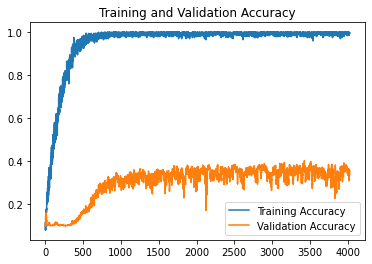

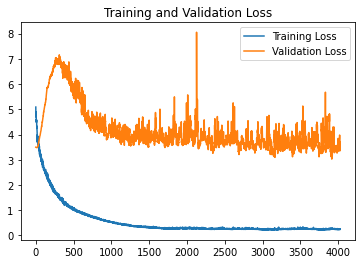

In [20]:
# show results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range((len(acc)))


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# pretext task with unlabeld data

## prepare data for pretext (Rotation Prediction)

create rotated image and save them in directory

In [ ]:
import os
import cv2
from matplotlib import pyplot as plt

!mkdir train
counter = 0

!mkdir train/z_angle
training_data = []
for i in range (len(x_unlabeld)):
  image = x_unlabeld[i]
  training_data.append(image)
  cv2.imwrite('/content/train/z_angle/image'+str(counter)+'.png',image) 
  counter = counter +1
print("zero degree rotation complete!")

!mkdir train/n_angle
training_data = []
for i in range (len(x_unlabeld)):
  image = x_unlabeld[i]
  image_aug = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
  training_data.append(image_aug)
  cv2.imwrite('/content/train/n_angle/image'+str(counter)+'.png',image_aug) 
  counter = counter +1
print("90 degree rotation complete!")

!mkdir train/e_angle
training_data = []
for i in range (len(x_unlabeld)):
  image = x_unlabeld[i]
  image_aug = cv2.rotate(image, cv2.ROTATE_180)
  training_data.append(image_aug)
  cv2.imwrite('/content/train/e_angle/image'+str(counter)+'.png',image_aug) 
  counter = counter +1
print("180 degree rotation complete!")

!mkdir train/m_angle
training_data = []
for i in range (len(x_unlabeld)):
  image = x_unlabeld[i]
  image_aug = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
  training_data.append(image_aug)
  cv2.imwrite('/content/train/m_angle/image'+str(counter)+'.png',image_aug) 
  counter = counter +1
print("270 degree rotation complete!")

zero degree rotation complete!
90 degree rotation complete!
180 degree rotation complete!
270 degree rotation complete!


show one example

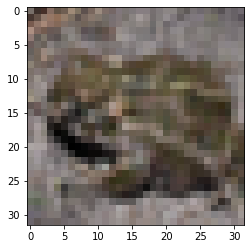

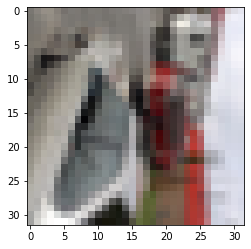

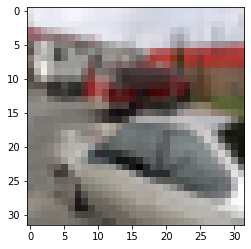

In [ ]:
from matplotlib import pyplot as plt
img = cv2.imread('/content/train/z_angle/image113.png') 
plt.imshow(img)
plt.show()
plt.imshow(image_aug)
plt.show()
plt.imshow(image)
plt.show()

collect all images in one directory

In [ ]:
import os
import shutil
!mkdir all_images
train_dir = '/content/train'
dest_dir = '/content/all_images'
counter = 0

for subdir, dirs, files in os.walk(train_dir):
    for file in files:
        full_path = os.path.join(subdir, file)
        shutil.copy(full_path, dest_dir)
        counter = counter + 1

print(counter) #199200 = 4 X 49800

199200


The next step is to store the name of each data point (ie name of each image) in one array (let’s name the array as filename). One more thing is to store the labels associated with each data point in another array(let’s call this array as labels).
Below is a script storing the names of each image in the filename array and labels associated with that image in labels array.
Note: Keep in mind that the name of each data point should be unique.

In [ ]:
import numpy as np

filenames = []
labels = np.zeros((counter, 1))

import os
import shutil

images_dir = '/content/all_images'
filenames_counter = 0
labels_counter = -1

for subdir, dirs, files in os.walk(train_dir):
    #print(files)
    for file in files:
        filenames.append(file)
        labels[filenames_counter, 0] = labels_counter
        filenames_counter = filenames_counter + 1
    labels_counter = labels_counter+1
    
print(len(filenames))
print(labels.shape)

199200
(199200, 1)


Now, you can save the “all_images” folder, “filename” array and the “labels” array for later use.

Below we create a numpy array of filename and labels and save them as a .npy file.

In [ ]:
# saving the filename array as .npy file
np.save('filenames.npy', filenames)

# One hot vector representation of labels
y_labels_one_hot = tf.keras.utils.to_categorical(labels)

# saving the y_labels_one_hot array as a .npy file
np.save('y_labels_one_hot.npy', y_labels_one_hot)

Shuffling and Splitting of the Dataset In Train and Validation Set.

The next step is to shuffle the dataset so as to remove any symmetry from our dataset.

In [ ]:
from sklearn.utils import shuffle

filenames_shuffled, y_labels_one_hot_shuffled = shuffle(filenames, y_labels_one_hot)

# saving the shuffled file.
# you can load them later using np.load().
np.save('y_labels_one_hot_shuffled.npy', y_labels_one_hot_shuffled)
np.save('filenames_shuffled.npy', filenames_shuffled)

Now, let’s split the dataset into a train and validation set. 

We can save these files also as these will be used later for training and validating of our model.

In [ ]:
from sklearn.model_selection import train_test_split

# Used this line as our filename array is not a numpy array.
filenames_shuffled_numpy = np.array(filenames_shuffled)

X_train_filenames, X_val_filenames, Y_train, Y_val = train_test_split(
    filenames_shuffled_numpy, y_labels_one_hot_shuffled, test_size=0.2, random_state=1)

print(X_train_filenames.shape) # (159360,) 
print(Y_train.shape)           # (159360, 4)

print(X_val_filenames.shape)   # (39840,)
print(Y_val.shape)             # (39840, 4)

# You can save these files as well. As you will be using them later for training and validation of your model.
np.save('X_train_filenames.npy', X_train_filenames)
np.save('y_train.npy', Y_train)

np.save('X_val_filenames.npy', X_val_filenames)
np.save('y_val.npy', Y_val)

(159360,)
(159360, 4)
(39840,)
(39840, 4)


These lines of code just create an “all_images.zip” folder.

In [ ]:
import shutil
shutil.make_archive("all_images", "zip", "all_images")

'/content/all_images.zip'

Creation of Custom Generator

Note: As our dataset is too large to fit in memory, we have to load the dataset from the hard disk in batches to our memory.

To do so, we are going to create a custom generator. Our Custom Generator is going to load the dataset from the hard disk in batches to memory.

In [ ]:
import cv2

class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    return np.array([
            (cv2.imread('/content/all_images/' + str(file_name)))
               for file_name in batch_x])/255.0, np.array(batch_y)

Ok, so we have created our data generator. Next step is to create instances of this class.

In [ ]:
batch_size = 512

my_training_batch_generator = My_Custom_Generator(X_train_filenames, Y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, Y_val, batch_size)

## train pretext model

In [ ]:
model = tf.keras.Sequential()

# define regularization norm 2
reg = tf.keras.regularizers.l2(0.001)

# input layer
# model.add(tf.keras.Input(X_train[0].shape))  # 32x32 RGB images
model.add(tf.keras.layers.Input((32,32,3)))

# create the base model
# First convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer=reg, name='conv_1'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_1'))
model.add(tf.keras.layers.Activation('relu', name='Act_1'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_1'))

# Second convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer=reg, name='conv_2'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_2'))
model.add(tf.keras.layers.Activation('relu', name='Act_2'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_2'))

# Third convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer=reg, name='conv_3'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_3'))
model.add(tf.keras.layers.Activation('relu', name='Act_3'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_3'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_3'))


# add a Flatten layer
model.add(tf.keras.layers.Flatten(name='Flatten'))

# let's add fully-connected layers
model.add(tf.keras.layers.Dense(1024, kernel_regularizer=reg, name='Dense_1'))
model.add(tf.keras.layers.Activation('relu', name='Act_4'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_4'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_4'))

model.add(tf.keras.layers.Dense(128, kernel_regularizer=reg, name='Dense_2'))
model.add(tf.keras.layers.Activation('relu', name='Act_5'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_5'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_5'))


# and a logistic layer -- let's say we have 4 classes[0, 90, 180, 270] degrees
model.add(tf.keras.layers.Dense(4, kernel_regularizer=reg, name='Dense_3'))
model.add(tf.keras.layers.Activation('softmax', name='Act_6'))

# compile the model
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=0.001), loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 128)       3584      
_________________________________________________________________
BatchN_1 (BatchNormalization (None, 30, 30, 128)       512       
_________________________________________________________________
Act_1 (Activation)           (None, 30, 30, 128)       0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 15, 15, 128)       0         
_________________________________________________________________
Drop_1 (Dropout)             (None, 15, 15, 128)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 13, 13, 128)       147584    
_________________________________________________________________
BatchN_2 (BatchNormalization (None, 13, 13, 128)       5

In [ ]:
# save the best weights to use in Downstream task
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="best_weights.hdf5", verbose=1, save_best_only=True)

# train and test the model on the unlabeld data for some epochs
history = model.fit_generator(generator=my_training_batch_generator,
                   steps_per_epoch = int(159360 // batch_size),
                   epochs = 200,
                   verbose = 1,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(39840 // batch_size),
                   callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
311/311 [==============================] - 59s 80ms/step - loss: 2.7910 - accuracy: 0.3452 - val_loss: 2.1579 - val_accuracy: 0.4228

Epoch 00001: val_loss improved from inf to 2.15787, saving model to best_weights.hdf5
Epoch 2/200
311/311 [==============================] - 24s 78ms/step - loss: 1.8355 - accuracy: 0.4954 - val_loss: 1.5852 - val_accuracy: 0.5531

Epoch 00002: val_loss improved from 2.15787 to 1.58522, saving model to best_weights.hdf5
Epoch 3/200
311/311 [==============================] - 24s 78ms/step - loss: 1.4092 - accuracy: 0.5435 - val_loss: 1.3887 - val_accuracy: 0.5066

Epoch 00003: val_loss improved from 1.58522 to 1.38870, saving model to best_weights.hdf5
Epoch 4/200
311/311 [==============================] - 24s 78ms/step - loss: 1.1950 - accuracy: 0.5765 - val_loss: 1.2496 - val_accuracy: 0.5556

Epoch 00004: val_loss improved from 1.38870 to 1.24955, saving model to best_weights.hdf5
Epoch 5/200
311/311 [==============================] - 24s 7

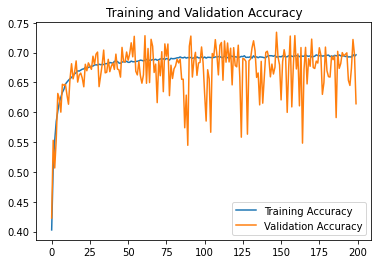

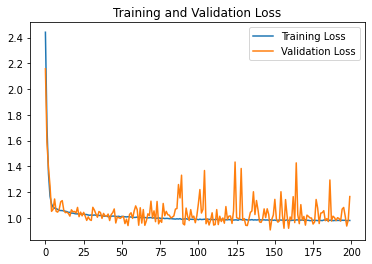

In [ ]:
# show results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range((len(acc)))


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Second model
training with 200 labeled data + pretrained weights

In [ ]:
model = tf.keras.Sequential()

# define regularization norm 2
reg = tf.keras.regularizers.l2(0.001)

# input layer
# model.add(tf.keras.Input(X_train[0].shape))  # 32x32 RGB images
model.add(tf.keras.layers.Input((32,32,3)))

# create the base model
# First convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer=reg, name='conv_1'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_1'))
model.add(tf.keras.layers.Activation('relu', name='Act_1'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_1'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_1'))

# Second convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer=reg, name='conv_2'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_2'))
model.add(tf.keras.layers.Activation('relu', name='Act_2'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_2'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_2'))

# Third convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer=reg, name='conv_3'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_3'))
model.add(tf.keras.layers.Activation('relu', name='Act_3'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_3'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_3'))


# add a Flatten layer
model.add(tf.keras.layers.Flatten(name='Flatten'))

# let's add fully-connected layers
model.add(tf.keras.layers.Dense(1024, kernel_regularizer=reg, name='Dense_1'))
model.add(tf.keras.layers.Activation('relu', name='Act_4'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_4'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_4'))

model.add(tf.keras.layers.Dense(128, kernel_regularizer=reg, name='Dense_2'))
model.add(tf.keras.layers.Activation('relu', name='Act_5'))
model.add(tf.keras.layers.BatchNormalization(name='BatchN_5'))
model.add(tf.keras.layers.Dropout(0.5, name='Drop_5'))


# and a logistic layer -- let's say we have 4 classes[0, 90, 180, 270] degrees
model.add(tf.keras.layers.Dense(4, kernel_regularizer=reg, name='Dense_3'))
model.add(tf.keras.layers.Activation('softmax', name='Act_6'))

# load weight layers of pretext model
model.load_weights('best_weights.hdf5')

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=["accuracy"])

# drop out last two layers of pretext model
model.pop()
model.pop()

# add two new layers. we have 10 classes in Downstream task
model.add(tf.keras.layers.Dense(10, kernel_regularizer=reg, name='10_clasifier'))
model.add(tf.keras.layers.Activation('softmax', name='Act_classifier'))

# compile the model
# use smaller learning rates
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=0.000008), loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 128)       3584      
_________________________________________________________________
BatchN_1 (BatchNormalization (None, 30, 30, 128)       512       
_________________________________________________________________
Act_1 (Activation)           (None, 30, 30, 128)       0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 15, 15, 128)       0         
_________________________________________________________________
Drop_1 (Dropout)             (None, 15, 15, 128)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 13, 13, 128)       147584    
_________________________________________________________________
BatchN_2 (BatchNormalization (None, 13, 13, 128)      

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=600)

# train the model on the 200 labeld data for some epochs with using pretext task weights
# test the model on the 10000 labeld data
history = model.fit(x_train, y_train,
                    batch_size=512,
                    epochs=6000,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    shuffle=True,
                    callbacks=[callback])

Streaming output truncated to the last 5000 lines.
Epoch 3501/6000
1/1 [==============================] - 0s 436ms/step - loss: 0.7074 - accuracy: 0.8700 - val_loss: 1.8599 - val_accuracy: 0.4507
Epoch 3502/6000
1/1 [==============================] - 0s 443ms/step - loss: 0.6931 - accuracy: 0.8500 - val_loss: 1.8594 - val_accuracy: 0.4509
Epoch 3503/6000
1/1 [==============================] - 0s 461ms/step - loss: 0.6748 - accuracy: 0.8700 - val_loss: 1.8596 - val_accuracy: 0.4506
Epoch 3504/6000
1/1 [==============================] - 0s 438ms/step - loss: 0.6895 - accuracy: 0.8800 - val_loss: 1.8592 - val_accuracy: 0.4508
Epoch 3505/6000
1/1 [==============================] - 0s 439ms/step - loss: 0.6836 - accuracy: 0.8700 - val_loss: 1.8590 - val_accuracy: 0.4511
Epoch 3506/6000
1/1 [==============================] - 0s 436ms/step - loss: 0.6497 - accuracy: 0.8800 - val_loss: 1.8591 - val_accuracy: 0.4508
Epoch 3507/6000
1/1 [==============================] - 0s 438ms/step - loss: 0.

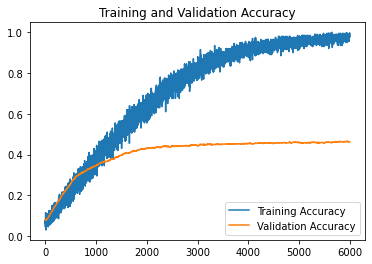

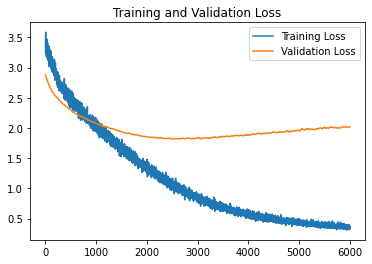

In [ ]:
# show result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range((len(acc)))


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()